# Sentiment Analysis - Model Development

## On Regular Feature-Engineered Data

### 1. CV+TF-IDF

In [1]:
import pandas as pd

# reading text-processed data
df=pd.read_csv("https://raw.githubusercontent.com/Alex-Mak-MCW/SpotifyDataScienceProject/main/Data/Sentiment_Analysis/CV_and_TFIDF.csv", encoding='utf-8')

In [2]:
print(df.shape) # (1621, 13104)
df.head()

(1621, 13104)


,track_name,artist,album,release_date,duration,popularity,explicit,lyrics,danceability,energy,...,zoo,zoom,zoomin,zoowap,ztrip,zucchini,zulema,zuli,zz,zzzzzzz
0,Blinding Lights,The Weeknd,After Hours,2020-03-20,200040,90,0,yeah tryna call long enough mayb show love may...,0.514,0.730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Shape of You,Ed Sheeran,÷ (Deluxe),2017-03-03,233712,86,0,club best place find lover bar go mm friend ta...,0.825,0.652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Someone You Loved,Lewis Capaldi,Divinely Uninspired To A Hellish Extent,2019-05-17,182160,89,0,go time fear one save noth realli got way driv...,0.501,0.405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,Hollywood's Bleeding,2019-09-06,157560,85,0,ayi ayi ayi ayi ooh ooh ooh ooh ooh ooh ayi ay...,0.755,0.522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,As It Was,Harry Styles,Harry's House,2022-05-20,167303,91,0,come harri want say goodnight holdin back grav...,0.520,0.731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Assign x and y assigning

# assign y as target variable
y=df.loc[:, df.columns =='mood'].values.ravel()

# Drop target variable in df
df.drop(['valence','mood', 'lyrics'], axis=1, inplace=True)

# Rest of the variables in df
x=df.iloc[:, 4:]

In [4]:
# data splitting (with options)
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.2)

# split the 20% by half (10% test, 10% validation)
X_val, X_test, y_val, y_test=train_test_split(X_test,y_test,test_size=0.5)

In [5]:
# verification

print("The shapes in the training dataset:")
print("X: ",X_train.shape)  # (1296, 13097)
print("Y: ",y_train.shape)  # (1296,)

print("The shapes in the valdiation dataset:")
print("X: ",X_val.shape)    # (162, 13097)
print("Y: ",y_val.shape)    # (162,)

print("The shapes in the testing dataset:")
print("X: ",X_test.shape)   # (163, 13097)
print("Y: ",y_test.shape)   # (163,)

The shapes in the training dataset:
X:  (1296, 13097)
Y:  (1296,)
The shapes in the valdiation dataset:
X:  (162, 13097)
Y:  (162,)
The shapes in the testing dataset:
X:  (163, 13097)
Y:  (163,)


#### 1.1 Logistic Regression Model

##### 1.1.1 Initialize and training the Model

In [6]:
# Model 1: basic LR (<5s)

# init and training the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Initialize and train the model with L1 regularization (Lasso)
LR = LogisticRegression()  # C is the inverse of regularization strength
LR.fit(X_train, y_train)

# Predict on the test set
LR_y_train_pred = LR.predict(X_train)

# Evaluate the model
LR_train_accuracy_pretuned = accuracy_score(y_train, LR_y_train_pred)
print("Training (Pre-tuned) Accuracy with LR: {}".format(LR_train_accuracy_pretuned))

Training (Pre-tuned) Accuracy with LR: 0.5254629629629629


##### 1.1.2 Model Hyperparameter Tuning

In [7]:
# Hyperparameter with randomized search CV (7 mins)
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

# Define Pipeline
LR_pipeline = Pipeline([
    # Variable Selection and Hyperparameter Tuning
    # ('feature_selection', SelectFromModel(LogisticRegression())),
    ('classifier', LogisticRegression())
])

# # Define param distributions for pipeline only
# LR_pipeline_param_distributions = {
#     'classifier__penalty': ['l1', 'l2', 'elasticnet'],
#     'classifier__C': uniform(loc=0.01, scale=0.99),  # Uniform distribution between 0.01 and 1
#     'classifier__tol': uniform(loc=1e-3, scale=0.099),  # Uniform distribution between 0.001 and 0.1
#     'classifier__max_iter': [500, 1000, 5000],  # Fixed choices
#     'classifier__solver': ['saga'],
#     'classifier__l1_ratio': uniform(loc=0, scale=1)  # Uniform distribution between 0 and 1 for ElasticNet
# }

# Perform Randomized Search CV (10: 2 min or 50: 16 mins)
# LR_random_search = RandomizedSearchCV(LR_pipeline, LR_pipeline_param_distributions, n_iter=50, cv=5, random_state=42)


# Define parameter grid
LR_pipeline_param_grid = {
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__C': [0.01, 0.1, 0.5, 1, 5, 10],
    'classifier__tol': [0.001, 0.01, 0.1],
    'classifier__max_iter': [500, 1000, 5000],
    'classifier__l1_ratio': [0, 0.25, 0.5, 0.75, 1]  # Only relevant for 'elasticnet'
}

# Perform Grid Search CV
LR_grid_search = GridSearchCV(LR_pipeline, LR_pipeline_param_grid, cv=5, verbose=1)

LR_grid_search.fit(X_val, y_val)

Fitting 5 folds for each of 810 candidates, totalling 4050 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.01, 0.1, 0.5, 1, 5, 10],
                         'classifier__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
                         'classifier__max_iter': [500, 1000, 5000],
                         'classifier__penalty': ['l1', 'l2', 'elasticnet'],
                         'classifier__tol': [0.001, 0.01, 0.1]},
             verbose=1)

In [8]:
# Retrieve the best estimator after random search CV is fitted
best_LR_estimator = LR_grid_search.best_estimator_

LR_val_accuracy = LR_grid_search.best_score_
print("Validation accuracy from Randomized Search CV: {}".format(LR_val_accuracy))

# Access the coefficients of the Logistic Regression model
lr_coefficients = best_LR_estimator.named_steps['classifier'].coef_[0]

# Identify the features with the highest absolute coefficients
top_indices = lr_coefficients.argsort()[-10:][::-1]  # Get indices of top 10 features
top_features = [X_val.columns[i] for i in top_indices]  # Get feature names from indices

# Extract the names of the top 10 features
print("Top 10 Most Important Features:")
for feature in top_features:
    print(feature)

Validation accuracy from Randomized Search CV: 0.5801136363636363
Top 10 Most Important Features:
popularity
loudness
time_signature
energy
danceability
danc
superman
tryin
yeah
oh


##### 1.1.3 Model Saving/ Loading

In [9]:
# Save tuned model and its best hyperparameters
import joblib

joblib.dump(LR_grid_search.best_estimator_, 'LR_model.pkl')
joblib.dump(LR_grid_search.best_params_,'LR_best_params.joblib')

['LR_best_params.joblib']

In [10]:
# # load the saved model (NOTE: uncomment only if needed)
# import joblib

# loaded_model=joblib.load('LR_model.pkl')
# loaded_model_best_params=joblib.load('LR_best_params.joblib')

##### 1.1.4 Model Predictions

In [11]:
# Refit the model with the best parameters
LR_pipeline.set_params(**LR_grid_search.best_params_,)
LR_pipeline.fit(X_train, y_train)


# Make predictions on the training set and calculate accuracy
LR_y_train_pred_tuned = LR_pipeline.predict(X_train)
LR_train_accuracy_posttuned = accuracy_score(y_train, LR_y_train_pred_tuned)
print("Training accuracy after tuning: {}".format(LR_train_accuracy_posttuned))

# Make predictions on the test set and calculate accuracy
LR_y_test_pred = LR_pipeline.predict(X_test)
LR_test_accuracy = accuracy_score(y_test, LR_y_test_pred)
print("Testing (Post-tuned) Accuracy from automated tuning on LR: {}".format(LR_test_accuracy))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Training accuracy after tuning: 0.5254629629629629
Testing (Post-tuned) Accuracy from automated tuning on LR: 0.5644171779141104


##### 1.1.5 Results Visualization

In [12]:
# Accuracy Comaprsion

print("Classification Accuracies for Linear Regression:")
print("---------------------------------------------------------------------")
print("Training Accuracy (Pre-tuned): \t\t{0:.2f}% \t({1})".format(LR_train_accuracy_pretuned*100, LR_train_accuracy_pretuned))
print("Training Accuracy (Post-tuned): \t{0:.2f}% \t({1})".format(LR_train_accuracy_posttuned*100, LR_train_accuracy_posttuned))

print("\nValidation Accuracy: \t\t\t{0:.2f}% \t({1})".format(LR_val_accuracy*100, LR_val_accuracy))
print("Testing Accuracy: \t\t\t{0:.2f}% \t({1})".format(LR_test_accuracy*100, LR_test_accuracy))

Classification Accuracies for Linear Regression:
---------------------------------------------------------------------
Training Accuracy (Pre-tuned): 		52.55% 	(0.5254629629629629)
Training Accuracy (Post-tuned): 	52.55% 	(0.5254629629629629)

Validation Accuracy: 			58.01% 	(0.5801136363636363)
Testing Accuracy: 			56.44% 	(0.5644171779141104)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.56      1.00      0.72        92
           1       0.00      0.00      0.00        71

    accuracy                           0.56       163
   macro avg       0.28      0.50      0.36       163
weighted avg       0.32      0.56      0.41       163



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

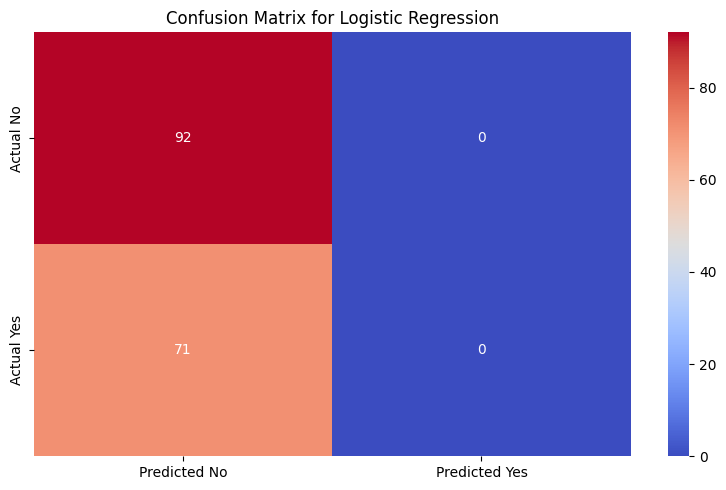

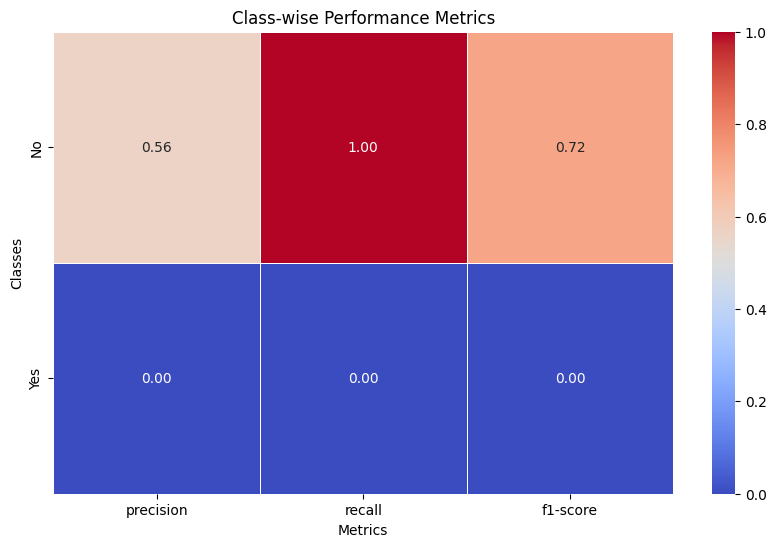

In [15]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Model Output
# Classification report
LR_classification_report=classification_report(y_test, LR_y_test_pred)
print(LR_classification_report)


# Confusion matrix with seaborn heatmap
LR_conf_matrix=confusion_matrix(y_test, LR_y_test_pred)
# Seaborn heatmap
plt.figure(figsize=(8,5))
sns.heatmap(LR_conf_matrix, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Logistic Regression')
plt.tight_layout()
plt.savefig("LR_confusion_matrix.png")


# Class-wise Performance Metrics
LR_classification_report_2 = classification_report(y_test, LR_y_test_pred, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
class_metrics = {metric: [LR_classification_report_2[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=pd.DataFrame(class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Class-wise Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig("LR_performance_metrics.png")
plt.show()

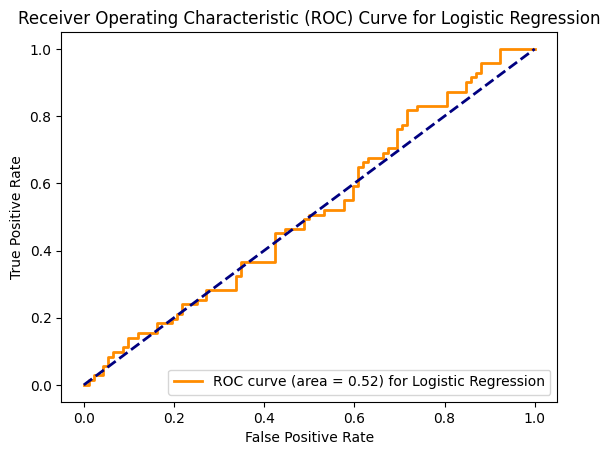

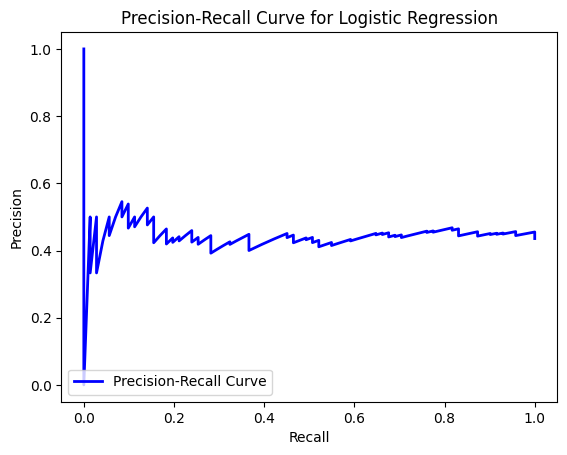

In [17]:
# More visualization
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# automate hyperparameter tuning (pipeline)
LR_y_scores=LR_pipeline.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, LR_y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f) for Logistic Regression' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.savefig("LR_roc_curve.png")

# Precision-Recall Curve (Keep it for now, can be deleted)
precision, recall, thresholds = precision_recall_curve(y_test, LR_y_scores)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend(loc="lower left")
plt.savefig("LR_precision_recall_curve.png")
plt.show()

#### 1.2 Naive Bayes Model

##### 1.2.1 Initialize and training the Model

In [37]:
import pandas as pd

# reading text-processed data
df=pd.read_csv("https://raw.githubusercontent.com/Alex-Mak-MCW/SpotifyDataScienceProject/main/Data/Sentiment_Analysis/CV_and_TFIDF.csv", encoding='utf-8')

In [38]:
print(df.shape) # (1621, 13104)
df.head()

(1621, 13104)


,track_name,artist,album,release_date,duration,popularity,explicit,lyrics,danceability,energy,...,zoo,zoom,zoomin,zoowap,ztrip,zucchini,zulema,zuli,zz,zzzzzzz
0,Blinding Lights,The Weeknd,After Hours,2020-03-20,200040,90,0,yeah tryna call long enough mayb show love may...,0.514,0.730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Shape of You,Ed Sheeran,÷ (Deluxe),2017-03-03,233712,86,0,club best place find lover bar go mm friend ta...,0.825,0.652,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Someone You Loved,Lewis Capaldi,Divinely Uninspired To A Hellish Extent,2019-05-17,182160,89,0,go time fear one save noth realli got way driv...,0.501,0.405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,Hollywood's Bleeding,2019-09-06,157560,85,0,ayi ayi ayi ayi ooh ooh ooh ooh ooh ooh ayi ay...,0.755,0.522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,As It Was,Harry Styles,Harry's House,2022-05-20,167303,91,0,come harri want say goodnight holdin back grav...,0.520,0.731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# NOTE: ONLY for Naive Bayes
# Shifting loudness to ensure all positive values, NB doesn't allow it

df['loudness']=df['loudness']+60
df['loudness']

0       54.066
1       56.817
2       54.321
3       55.632
4       54.662
         ...  
1616    47.373
1617    55.386
1618    45.939
1619    49.720
1620    55.511
Name: loudness, Length: 1621, dtype: float64

In [41]:
# Assign x and y assigning

# assign y as target variable
y=df.loc[:, df.columns =='mood'].values.ravel()

# Drop target variable in df
df.drop(['valence','mood', 'lyrics'], axis=1, inplace=True)

# Rest of the variables in df
x=df.iloc[:, 4:]

In [42]:
# data splitting (with options)
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test=train_test_split(x,y,test_size=0.2)

# split the 20% by half (10% test, 10% validation)
X_val, X_test, y_val, y_test=train_test_split(X_test,y_test,test_size=0.5)

In [43]:
# verification

print("The shapes in the training dataset:")
print("X: ",X_train.shape)  # (1296, 13097)
print("Y: ",y_train.shape)  # (1296,)

print("The shapes in the valdiation dataset:")
print("X: ",X_val.shape)    # (162, 13097)
print("Y: ",y_val.shape)    # (162,)

print("The shapes in the testing dataset:")
print("X: ",X_test.shape)   # (163, 13097)
print("Y: ",y_test.shape)   # (163,)

The shapes in the training dataset:
X:  (1296, 13097)
Y:  (1296,)
The shapes in the valdiation dataset:
X:  (162, 13097)
Y:  (162,)
The shapes in the testing dataset:
X:  (163, 13097)
Y:  (163,)


In [44]:
# Model 2: Naive Bayes (<5s)

# init and training the model
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Initialize and train the model with L1 regularization (Lasso)
MNB = MultinomialNB()  # C is the inverse of regularization strength
MNB.fit(X_train, y_train)

# Predict on the train set
MNB_y_train_pred = MNB.predict(X_train)

# Evaluate the model
MNB_train_accuracy_pretuned = accuracy_score(y_train, MNB_y_train_pred)
print("Training (Pre-tuned) Accuracy with Gaussian Naive Bayes: {}".format(MNB_train_accuracy_pretuned))

Training (Pre-tuned) Accuracy with Gaussian Naive Bayes: 0.5848765432098766


##### 1.2.2 Model Hyperparameter Tuning

In [45]:
# Hyperparameter with randomized search CV (7 mins)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Define the pipeline
MNB_pipeline = Pipeline([
    ('classifier', MultinomialNB())  # Multinomial Naive Bayes classifier
])

# Define parameter grid for GridSearchCV
MNB_pipeline_param_grid = {
    'classifier__alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0],  # Smoothing parameter
    'classifier__fit_prior': [True, False]  # Whether to learn class prior probabilities
}

# Perform Grid Search CV
MNB_grid_search = GridSearchCV(MNB_pipeline, MNB_pipeline_param_grid, cv=5, verbose=1)
MNB_grid_search.fit(X_val, y_val)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('classifier', MultinomialNB())]),
             param_grid={'classifier__alpha': [0.01, 0.05, 0.1, 0.5, 1.0, 5.0,
                                               10.0],
                         'classifier__fit_prior': [True, False]},
             verbose=1)

In [47]:
# Retrieve the best estimator after Grid Search CV is fitted
best_MNB_estimator = MNB_grid_search.best_estimator_

MNB_val_accuracy = MNB_grid_search.best_score_
print("Validation accuracy from Randomized Search CV: {}".format(MNB_val_accuracy))

# Assuming your feature names are stored in a list called 'feature_names'
MNB_feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(X_train.shape[1])

# Access the feature log probabilities
MNB_feature_log_probs = best_MNB_estimator.named_steps['classifier'].feature_log_prob_

# For a binary classification problem (two classes), you can look at the difference in log probabilities
# for the positive class (e.g., class 1) vs the negative class (e.g., class 0)
class_0_log_probs = MNB_feature_log_probs[0]
class_1_log_probs = MNB_feature_log_probs[1]

# Calculate the difference in log probabilities
MNB_log_prob_diff = class_1_log_probs - class_0_log_probs

# Identify the features with the highest absolute log probability differences
MNB_top_indices = MNB_log_prob_diff.argsort()[-10:][::-1]  # Get indices of top 10 features
MNB_top_features = [MNB_feature_names[i] for i in MNB_top_indices]  # Get feature names from indices

# Extract the names of the top 10 features
print("Top 10 Most Important Features:")
for feature in MNB_top_features:
    print(feature)


Validation accuracy from Randomized Search CV: 0.5801136363636363
Top 10 Most Important Features:
superman
doodoodoo
awe
uptown
sugar
taint
treasur
yellow
psycho
uhhuh


##### 1.1.3 Model Saving/ Loading

In [48]:
# Save tuned model and its best hyperparameters
import joblib

joblib.dump(MNB_grid_search.best_estimator_, 'MNB_model.pkl')
joblib.dump(MNB_grid_search.best_params_,'MNB_best_params.joblib')

['MNB_best_params.joblib']

In [49]:
# # load the saved model (NOTE: uncomment only if needed)
# import joblib

# loaded_model=joblib.load('MNB_model.pkl')
# loaded_model_best_params=joblib.load('MNB_best_params.joblib')

##### 1.1.4 Model Predictions

In [50]:
# Refit the model with the best parameters
MNB_pipeline.set_params(**MNB_grid_search.best_params_,)
MNB_pipeline.fit(X_train, y_train)

# Make predictions on the training set and calculate accuracy
MNB_y_train_pred_tuned = MNB_pipeline.predict(X_train)
MNB_train_accuracy_posttuned = accuracy_score(y_train, MNB_y_train_pred_tuned)
print("Training accuracy after tuning: {}".format(MNB_train_accuracy_posttuned))

# Make predictions on the test set and calculate accuracy
MNB_y_test_pred = MNB_pipeline.predict(X_test)
MNB_test_accuracy = accuracy_score(y_test, MNB_y_test_pred)
print("Testing (Post-tuned) Accuracy from automated tuning on LR: {}".format(MNB_test_accuracy))

Training accuracy after tuning: 0.7515432098765432
Testing (Post-tuned) Accuracy from automated tuning on LR: 0.6012269938650306


##### 1.1.5 Results Visualization

In [51]:
# Accuracy Comaprsion

print("Classification Accuracies for Multinomial Naive Bayes (NB):")
print("---------------------------------------------------------------------")
print("Training Accuracy (Pre-tuned): \t\t{0:.2f}% \t({1})".format(MNB_train_accuracy_pretuned*100, MNB_train_accuracy_pretuned))
print("Training Accuracy (Post-tuned): \t{0:.2f}% \t({1})".format(MNB_train_accuracy_posttuned*100, MNB_train_accuracy_posttuned))

print("\nValidation Accuracy: \t\t\t{0:.2f}% \t({1})".format(MNB_val_accuracy*100, MNB_val_accuracy))
print("Testing Accuracy: \t\t\t{0:.2f}% \t({1})".format(MNB_test_accuracy*100, MNB_test_accuracy))

Classification Accuracies for Multinomial Naive Bayes (NB):
---------------------------------------------------------------------
Training Accuracy (Pre-tuned): 		58.49% 	(0.5848765432098766)
Training Accuracy (Post-tuned): 	75.15% 	(0.7515432098765432)

Validation Accuracy: 			58.01% 	(0.5801136363636363)
Testing Accuracy: 			60.12% 	(0.6012269938650306)


              precision    recall  f1-score   support

           0       0.62      0.64      0.63        87
           1       0.58      0.55      0.56        76

    accuracy                           0.60       163
   macro avg       0.60      0.60      0.60       163
weighted avg       0.60      0.60      0.60       163



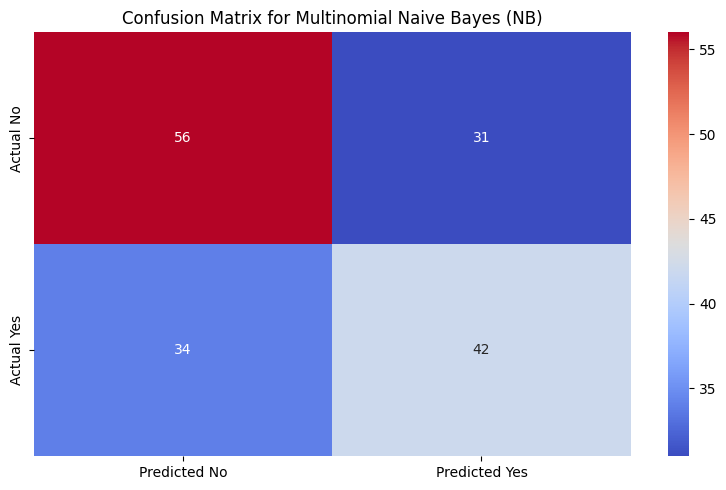

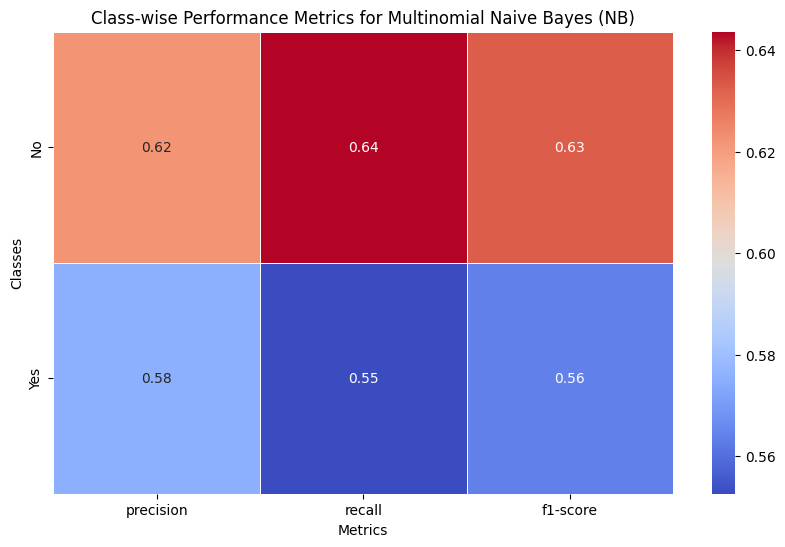

In [53]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Model Output
# Classification report
MNB_classification_report=classification_report(y_test, MNB_y_test_pred)
print(MNB_classification_report)


# Confusion matrix with seaborn heatmap
MNB_conf_matrix=confusion_matrix(y_test, MNB_y_test_pred)
# Seaborn heatmap
plt.figure(figsize=(8,5))
sns.heatmap(MNB_conf_matrix, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix for Multinomial Naive Bayes (NB)')
plt.tight_layout()
plt.savefig("MNB_confusion_matrix.png")


# Class-wise Performance Metrics
MNB_classification_report_2 = classification_report(y_test, MNB_y_test_pred, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
MNB_class_metrics = {metric: [MNB_classification_report_2[class_name][metric] for class_name in ['0','1']] for metric in metrics}

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data=pd.DataFrame(MNB_class_metrics, index=['No','Yes']), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Class-wise Performance Metrics for Multinomial Naive Bayes (NB)')
plt.xlabel('Metrics')
plt.ylabel('Classes')
plt.savefig("MNB_performance_metrics.png")
plt.show()

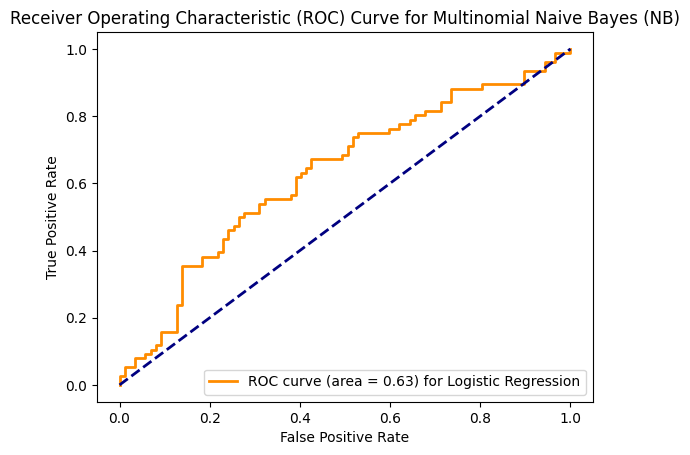

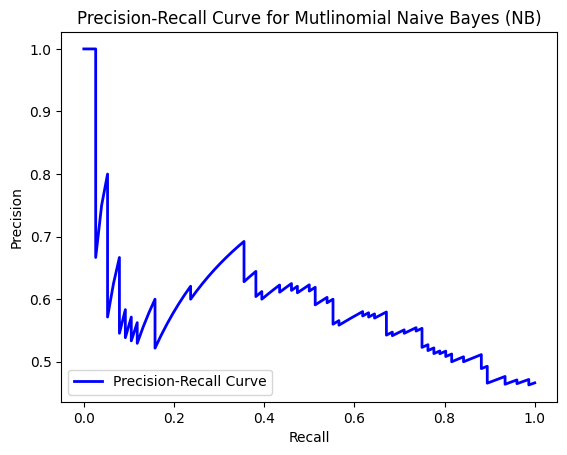

In [55]:
# More visualization
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# automate hyperparameter tuning (pipeline)
MNB_y_scores=MNB_pipeline.predict_proba(X_test)[:, 1]

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, MNB_y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f) for Logistic Regression' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multinomial Naive Bayes (NB)')
plt.legend(loc="lower right")
plt.savefig("MNB_roc_curve.png")

# Precision-Recall Curve (Keep it for now, can be deleted)
precision, recall, thresholds = precision_recall_curve(y_test, MNB_y_scores)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Mutlinomial Naive Bayes (NB)')
plt.legend(loc="lower left")
plt.savefig("MNB_precision_recall_curve.png")
plt.show()

#### 1.3 Support Vector Machine (SVM)

## On Combined Feature-Engineered Data